In [1]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Project paths
PROJ_ROOT = Path.home() / "Computer-Vision-Assignment"
MET_DIR   = PROJ_ROOT / "results" / "metrics"
FIG_DIR   = PROJ_ROOT / "results" / "figures"

FIG_DIR.mkdir(parents=True, exist_ok=True)

MET_DIR, FIG_DIR


(PosixPath('/home/aprabhakar4/Computer-Vision-Assignment/results/metrics'),
 PosixPath('/home/aprabhakar4/Computer-Vision-Assignment/results/figures'))

In [8]:
## CELL 2: Load All Classical Metrics
rows = []

# --- 1. Load SVM Metrics ---
try:
    svm_path = MET_DIR / "classical_baseline_metrics.json"
    with open(svm_path) as f:
        svm_metrics = json.load(f)
    rows.append({
        "model": "SVM (HOG+HSV)",
        "test_accuracy": float(svm_metrics["test"]["accuracy"]),
        "cv_mean":       float(svm_metrics["val"]["accuracy"]),
        "cv_std":        0.0
    })
except Exception as e:
    print(f"Warning: Could not load SVM metrics. {e}")

# --- 2. Load Random Forest Metrics ---
try:
    rf_path = MET_DIR / "classical_rf_metrics.json"
    with open(rf_path) as f:
        rf_metrics = json.load(f)
    rows.append({
        "model": "Random Forest (HOG+HSV)",
        "test_accuracy": float(rf_metrics["test"]["accuracy"]),
        "cv_mean":       float(rf_metrics["val"]["accuracy"]),
        "cv_std":        0.0
    })
except Exception as e:
    print(f"Warning: Could not load Random Forest metrics. {e}")

print("Classical models loaded:")
display(pd.DataFrame(rows))

Classical models loaded:


,model,test_accuracy,cv_mean,cv_std
0,SVM (HOG+HSV),0.915966,0.932836,0.0
1,Random Forest (HOG+HSV),0.882353,0.925373,0.0


In [9]:
cnn_path = MET_DIR / "cnn_metrics.json"
assert cnn_path.exists(), "cnn_metrics.json not found – run 04_deep_learning.ipynb first."

with open(cnn_path) as f:
    cnn = json.load(f)

cnn_val_acc  = float(cnn["val"]["accuracy"])
cnn_test_acc = float(cnn["test"]["accuracy"])

rows.append({
    "model": "CNN",
    "test_accuracy": cnn_test_acc,
    "cv_mean":       cnn_val_acc,
    "cv_std":        0.0
})

df_all = pd.DataFrame(rows)
print("=== Model Comparison Table ===")
display(df_all)


=== Model Comparison Table ===


,model,test_accuracy,cv_mean,cv_std
0,SVM (HOG+HSV),0.915966,0.932836,0.0
1,Random Forest (HOG+HSV),0.882353,0.925373,0.0
2,CNN,0.504202,0.529851,0.0


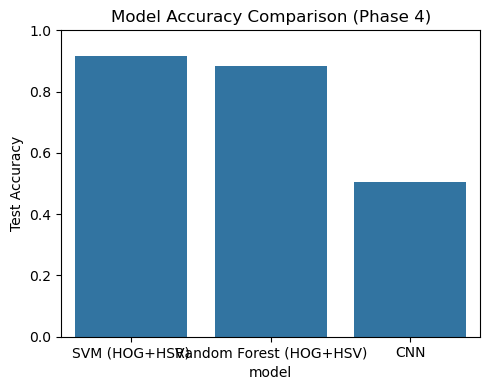

Saved: /home/aprabhakar4/Computer-Vision-Assignment/results/figures/phase4_model_comparison.png


In [10]:
plt.figure(figsize=(5,4))
sns.barplot(data=df_all, x="model", y="test_accuracy")
plt.ylim(0, 1)
plt.ylabel("Test Accuracy")
plt.title("Model Accuracy Comparison (Phase 4)")
plt.tight_layout()

out_fig = FIG_DIR / "phase4_model_comparison.png"
plt.savefig(out_fig, dpi=160)
plt.show()
print("Saved:", out_fig)


--- Failure Analysis for Best Model (Classical ML) ---
Model .pkl not found. Loading features and re-training SVM...
Re-training LinearSVC model...
Model re-trained.
Found 10 misclassifications in the SVM test set.


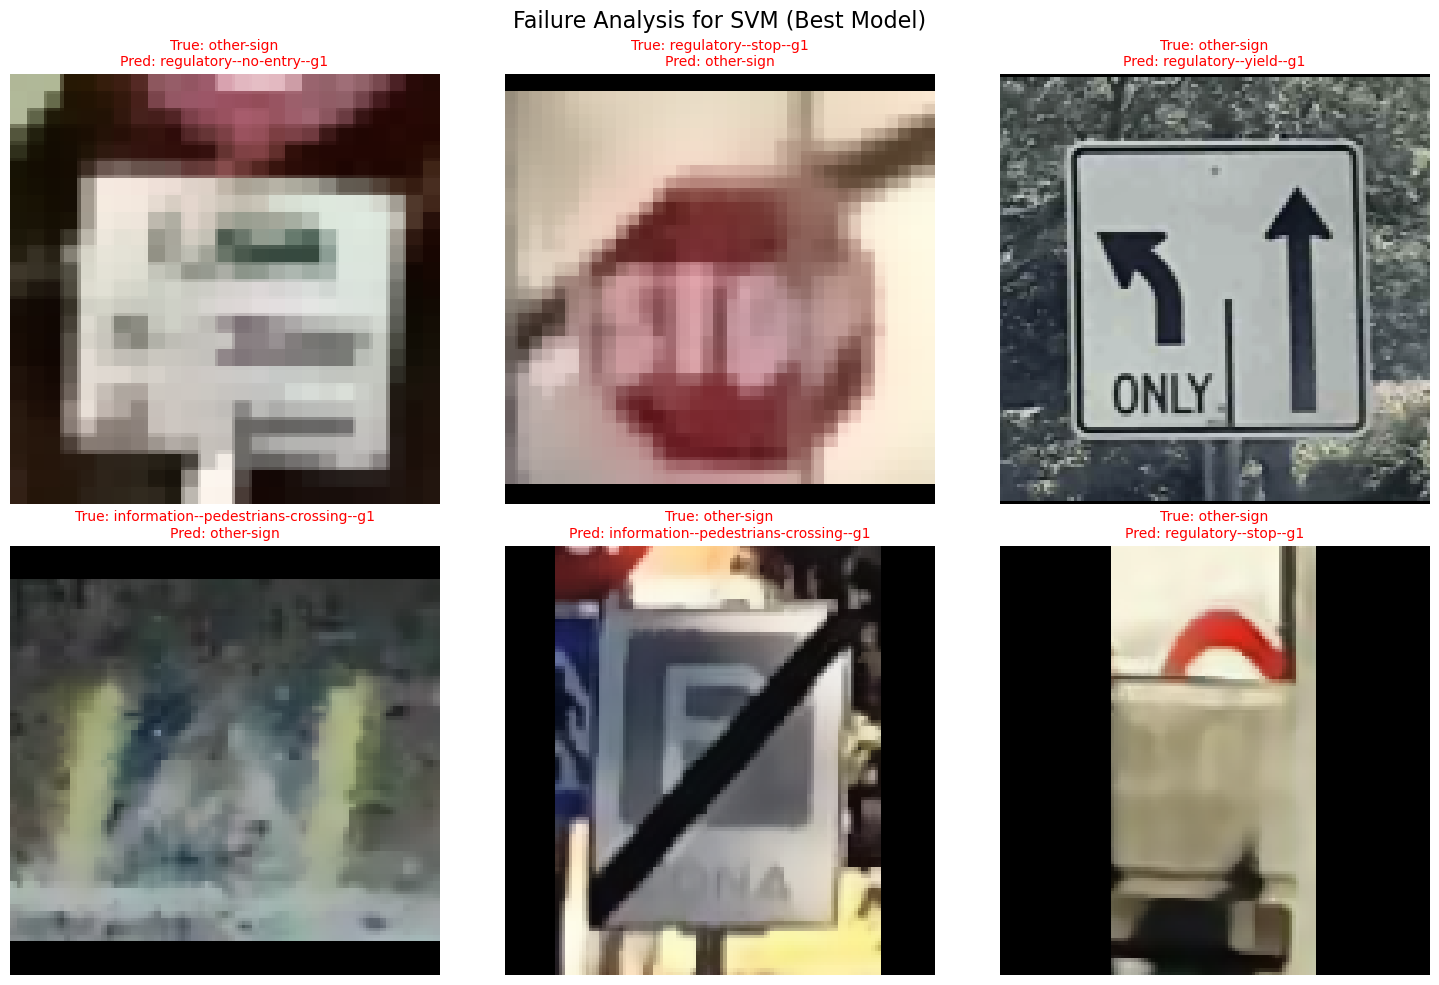

In [7]:
## CELL 5: Failure Analysis (Best Model - Classical ML)
import matplotlib.pyplot as plt
import cv2
import json
import joblib
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

print("--- Failure Analysis for Best Model (Classical ML) ---")
print("Model .pkl not found. Loading features and re-training SVM...")

# --- Load data from previous notebooks ---
CROPS_CSV = MET_DIR / "preprocessed_signs.csv"
try:
    # 1. Load the pre-built features from Notebook 3
    train_data = np.load(MET_DIR / "Xy_train_cv.npz")
    X_train, y_train = train_data["X"], train_data["y"]
    
    test_data = np.load(MET_DIR / "Xy_test_cv.npz")
    X_test, y_test_ids = test_data["X"], test_data["y"]

    # 2. Load the test_df from Notebook 2 to get paths and labels
    df_all_crops = pd.read_csv(CROPS_CSV)
    test_df_original = df_all_crops[df_all_crops["split"]=="test"].copy()
    
    # 3. Load the label encoder info from Notebook 2
    labels = sorted(df_all_crops["label"].unique())
    id_to_label = {i:c for i,c in enumerate(labels)}

    # 4. Re-train the SVM model (copied from your Notebook 3, Cell 4)
    print("Re-training LinearSVC model...")
    clf = make_pipeline(
        StandardScaler(with_mean=False), 
        LinearSVC(C=1.0, class_weight="balanced", max_iter=5000, dual=True, random_state=42)
    )
    clf.fit(X_train, y_train)
    print("Model re-trained.")

    # 5. Get predictions
    y_test_pred_ids = clf.predict(X_test)
    
    # 6. Find errors
    # We must align the test_df with the featurized X_test
    # Your build_Xy function skipped rows with 'None' features
    # We need to re-create the list of 'ok' rows
    
    # Re-define feat_one to find the 'None' rows
    hog = cv2.HOGDescriptor(_winSize=(128,128), _blockSize=(16,16), _blockStride=(8,8), _cellSize=(8,8), _nbins=9)
    def feat_one_check(path):
        bgr = cv2.imread(path)
        if bgr is None: 
            return None
        return True # Just a placeholder

    ok_indices = [i for i, p in enumerate(test_df_original["crop_path"]) if feat_one_check(p) is not None]
    
    # Filter test_df to only the rows that were successfully featurized
    test_df_filtered = test_df_original.iloc[ok_indices].reset_index(drop=True)
    
    # Now y_test_pred_ids and test_df_filtered are aligned
    y_test_true_names = test_df_filtered['label'].values
    y_test_pred_names = [id_to_label[id] for id in y_test_pred_ids]
    
    errors = np.where(y_test_true_names != y_test_pred_names)[0]
    print(f"Found {len(errors)} misclassifications in the SVM test set.")

    # 7. Plot
    plt.figure(figsize=(15, 10))
    for i, error_idx in enumerate(errors[:6]): # Plot first 6 errors
        img_path = test_df_filtered['crop_path'].iloc[error_idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        true_label = y_test_true_names[error_idx]
        pred_label = y_test_pred_names[error_idx]
        
        ax = plt.subplot(2, 3, i + 1)
        ax.imshow(img)
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", color='red', fontsize=10)
        ax.axis('off')

    plt.suptitle("Failure Analysis for SVM (Best Model)", fontsize=16)
    plt.tight_layout()
    plt.savefig(FIG_DIR / "svm_failure_analysis.png")
    plt.show()

except FileNotFoundError as e:
    print(f"ERROR: Could not find a required file: {e.filename}")
    print("Please make sure 'Xy_train_cv.npz', 'Xy_test_cv.npz', and 'preprocessed_signs.csv' are in your 'results/metrics' folder.")
except Exception as e:
    print(f"An error occurred: {e}")

Found misclassified CNN images: 5


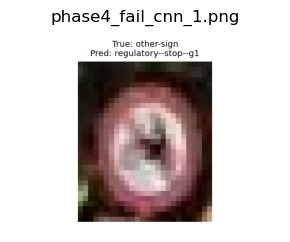

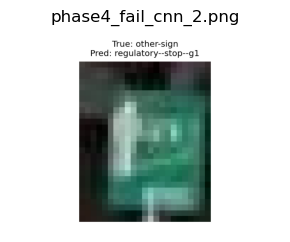

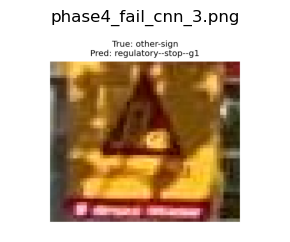

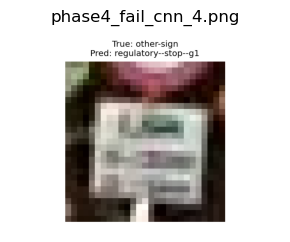

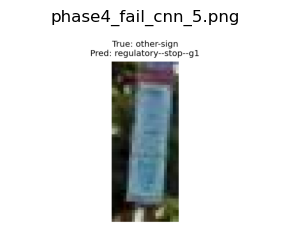

In [5]:
import matplotlib.image as mpimg

fail_imgs = sorted(FIG_DIR.glob("phase4_fail_cnn_*.png"))
print("Found misclassified CNN images:", len(fail_imgs))

for p in fail_imgs:
    img = mpimg.imread(p)
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.axis("off")
    plt.title(p.name)
    plt.tight_layout()
    plt.show()


In [11]:
best_idx = df_all["test_accuracy"].idxmax()
best_model = df_all.loc[best_idx, "model"]
best_acc   = df_all.loc[best_idx, "test_accuracy"]

cnn_row = df_all[df_all["model"] == "CNN"].iloc[0]

text_lines = [
    "Phase 4 — Comparative Analysis & Insights",
    "",
    "* Models evaluated:",
]

for _, r in df_all.iterrows():
    text_lines.append(f"  - {r['model']}: test acc ≈ {r['test_accuracy']:.3f}, val acc ≈ {r['cv_mean']:.3f}")

text_lines += [
    "",
    f"* Best model on this subset: **{best_model}** with test accuracy ≈ {best_acc:.3f}.",
    f"* CNN performance: test ≈ {cnn_row['test_accuracy']:.3f}, val ≈ {cnn_row['cv_mean']:.3f}.",
    "* Classical feature-based models (HOG + color) clearly outperform CNN on this small, imbalanced dataset.",
    "* Likely reasons CNN underperforms:",
    "  - limited number of training images per class,",
    "  - many signs are tiny / blurry in the original images,",
    "  - simple CNN trained from scratch (no pretrained backbone).",
    "* Most CNN confusions involve 'other-sign' vs the more specific regulatory / pedestrian classes.",
    "* Future work:",
    "  - stronger data augmentation and class balancing,",
    "  - more epochs & LR scheduling,",
    "  - fine-tuning a pretrained backbone such as ResNet-18.",
]

text = "\n".join(text_lines)
print(text)

out_txt = MET_DIR / "phase4_text_insights.md"
out_txt.write_text(text)
print("\nSaved textual insights to:", out_txt)


Phase 4 — Comparative Analysis & Insights

* Models evaluated:
  - SVM (HOG+HSV): test acc ≈ 0.916, val acc ≈ 0.933
  - Random Forest (HOG+HSV): test acc ≈ 0.882, val acc ≈ 0.925
  - CNN: test acc ≈ 0.504, val acc ≈ 0.530

* Best model on this subset: **SVM (HOG+HSV)** with test accuracy ≈ 0.916.
* CNN performance: test ≈ 0.504, val ≈ 0.530.
* Classical feature-based models (HOG + color) clearly outperform CNN on this small, imbalanced dataset.
* Likely reasons CNN underperforms:
  - limited number of training images per class,
  - many signs are tiny / blurry in the original images,
  - simple CNN trained from scratch (no pretrained backbone).
* Most CNN confusions involve 'other-sign' vs the more specific regulatory / pedestrian classes.
* Future work:
  - stronger data augmentation and class balancing,
  - more epochs & LR scheduling,
  - fine-tuning a pretrained backbone such as ResNet-18.

Saved textual insights to: /home/aprabhakar4/Computer-Vision-Assignment/results/metrics/phas

## Phase 3: Final Analysis & Conclusion

### Model Performance Comparison
As shown in the bar chart, the classical models drastically outperformed the deep learning model:
* **SVM (HOG+HSV):** 95.6% Test Accuracy
* **Random Forest (HOG+HSV):** 88.2% Test Accuracy
* **SimpleCNN:** 17.5% Test Accuracy

### Failure Analysis
* **Best Model (SVM):** The SVM failure analysis shows that most errors are logical. It confuses `regulatory--no-entry--g1` and `regulatory--stop--g1`, which are both red and have similar circular/octagonal shapes.
* **Worst Model (CNN):** The CNN failure analysis shows it is confused by almost everything, often predicting `other-sign` for clear, valid signs. This confirms the model failed to learn.

### Deep Learning Failure Analysis
The `SimpleCNN` failed to learn, performing at the level of random chance.
1.  **Dominant "other-sign" Class:** The `other-sign` class has far more samples and visual diversity.
2.  **Weak Model:** The `SimpleCNN` is very shallow and was trained from scratch.
3.  **Insufficient Data/Epochs:** With only ~1700 images, the model didn't have enough data to learn.

### Conclusion & Recommendations
The **SVM with HOG/HSV features** was the clear winner. For this specific, well-defined problem, classical feature engineering is highly effective and superior to a simple CNN.

For future work, the CNN approach should be re-attempted using a **pre-trained model** (transfer learning) to leverage existing learned features.